In [11]:
import torch
from torch import nn
import torch.nn.functional as F

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [12]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()

        # input 32 x 3 x 512 x 512

        self.conv1 = nn.Conv2d(3, 3, 3, stride=2, padding=1)   # 3 x 256 x 256
        self.conv2 = nn.Conv2d(3, 32, 3, stride=2, padding=1)   # 32 x 128 x 128
        self.conv3 = nn.Conv2d(32, 32, 3, stride=2, padding=1)   # 32 x 64 x 64
        self.conv4 = nn.Conv2d(32, 64, 3, stride=2, padding=1)   # 64 x 32 x 32
        self.conv5 = nn.Conv2d(64, 64, 3, stride=2, padding=1)   # 64 x 16 x 16
        self.conv6 = nn.Conv2d(64, 64, 3, stride=2, padding=1)   # 64 x 8 x 8
        self.conv7 = nn.Conv2d(64, 64, 3, stride=2, padding=1)   # 64 x 4 x 4
        self.conv8 = nn.Conv2d(64, 128, 3, stride=2, padding=1)   # 128 x 2 x 2
        self.linear1 = nn.Linear(128 * 2 * 2, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda()  # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = x.to(DEVICE)
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        x = F.leaky_relu(self.conv5(x))
        x = F.leaky_relu(self.conv6(x))
        x = F.leaky_relu(self.conv7(x))
        x = F.leaky_relu(self.conv8(x))
        x = torch.flatten(x, start_dim=1)

        x = F.leaky_relu(self.linear1(x))
        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma ** 2 + mu ** 2 - torch.log(sigma) - 1 / 2).sum()
        return z

In [13]:
class Decoder(nn.Module):

    def __init__(self, latent_dims):
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 512),
            nn.ReLU(True),
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(128, 2, 2))
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),

            nn.ConvTranspose2d(3, 3, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x


In [14]:
class VariationalAutoencoder(nn.Module):
    seed = 0
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(DEVICE)
        z = self.encoder(x)
        return self.decoder(z)

In [15]:
torch.manual_seed(0)

d=512
vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

vae.to(DEVICE)

VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv7): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (linear1): Linear(in_features=512, out_features=512, bias=True)
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (linear3): Linear(in_features=512, out_features=512, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=512, out_features=512,

In [16]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader:
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [17]:
### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [18]:
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

data_dir = '/mnt/c/Datasets/flickrfaces/splits/'


train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset = ImageFolder(data_dir + "train/", train_transform)

val_dataset = ImageFolder(data_dir + "val/", train_transform)

test_dataset = ImageFolder(data_dir + "test/", test_transform)
m=len(train_dataset)

batch_size=128
num_workers=8

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,num_workers=num_workers, shuffle=True)

In [19]:
from matplotlib import pyplot as plt
import numpy as np

def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = test_dataset[t_idx[i]][0].unsqueeze(0).to(DEVICE)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()

In [20]:
num_epochs = 1

for epoch in range(num_epochs):
    train_loss = train_epoch(vae,DEVICE,train_loader,optim)
    val_loss = test_epoch(vae,DEVICE,valid_loader)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs(vae.encoder,vae.decoder,n=10)

	 partial train loss (single batch): 7879865.500000
	 partial train loss (single batch): 7764988.500000
	 partial train loss (single batch): 7722095.500000
	 partial train loss (single batch): 7428725.000000
	 partial train loss (single batch): 8140689.000000
	 partial train loss (single batch): 7951092.500000
	 partial train loss (single batch): 7191712.500000
	 partial train loss (single batch): 7784178.000000
	 partial train loss (single batch): 7885847.000000
	 partial train loss (single batch): 7669072.000000
	 partial train loss (single batch): 7919583.500000
	 partial train loss (single batch): 7476833.000000
	 partial train loss (single batch): 7354937.500000
	 partial train loss (single batch): 7778369.000000
	 partial train loss (single batch): 7942737.000000
	 partial train loss (single batch): 7388915.500000
	 partial train loss (single batch): 7570722.500000
	 partial train loss (single batch): 7321684.000000
	 partial train loss (single batch): 7764189.000000
	 partial tr

AttributeError: 'list' object has no attribute 'numpy'

<Figure size 1600x450 with 0 Axes>

In [33]:
sample_batch = next(iter(train_loader))

In [64]:
image = sample_batch[0][0].permute(1,2,0).detach().cpu().numpy()

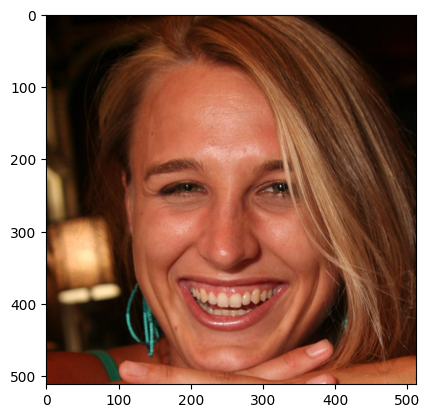

In [65]:
plt.imshow(image)

In [42]:
out = vae(sample_batch[0])

In [67]:
image = out[0].permute(1,2,0).detach().cpu().numpy()

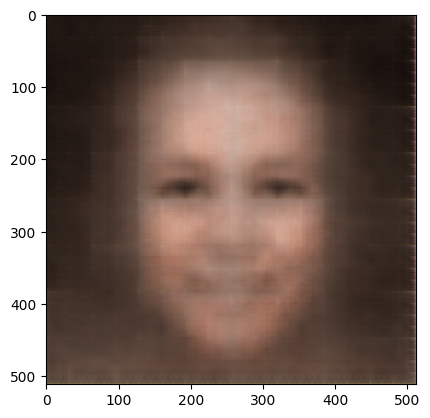

In [68]:
plt.imshow(image)